## *ESSENTIAL LIBRARY IMPORTS*

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

from tqdm import tqdm
import xml.etree.ElementTree as ET

from torch import nn, optim
from torch import autograd
import torch.nn.functional as F
from torch.nn import Parameter
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset,DataLoader,Subset
from PIL import Image,ImageOps,ImageEnhance

## *FETCHING THE DATASET*

The dataset consists of a large collection of images, with each image corresponding to a specific dog breed. It covers a wide range of dog breeds, including popular ones like Labrador Retriever, German Shepherd, Chihuahua, and many others. The dataset provides a diverse set of images capturing various angles, poses, and appearances of different dog breeds.

Each image in the dataset is accompanied by annotations, which include the bounding box coordinates and the corresponding breed label. These annotations are valuable for tasks such as object detection and localization. The dataset also includes a hierarchical taxonomy of dog breeds, which provides a hierarchical structure for the breeds based on their lineage.

The Stanford Dogs dataset has been widely used for training and evaluating deep learning models in the field of computer vision. Researchers and practitioners leverage this dataset to develop algorithms that can recognize and classify dog breeds accurately. It has also been used as a benchmark dataset for evaluating the performance of different image recognition models.

In [10]:
# Setting the Paths to the dataset Folders

image_path = 'C:/Users/nitya/OneDrive/Documents/GitHub Docs/EE240/Project/Datasets/all-dogs/all-dogs'
annotations_path = 'C:/Users/nitya/OneDrive/Documents/GitHub Docs/EE240/Project/Datasets/Annotation/Annotation'

## *PREPROCESSING*

In [11]:
# Specifying Parameters
BATCH_SIZE = 32
NUM_WORKERS = 4
EMA = False
LABEL_NOISE = False
LABEL_NOISE_PROB = 0.1

In [12]:
images_path = image_path

img_filenames = []
for dirpath, dirnames, filenames in os.walk(images_path):
    img_filenames.extend(filenames)

print(len(img_filenames))

20579


In [13]:
annotations = []

# os.walk() generates the file names in a directory tree
for subdir, dirs, files in os.walk(annotations_path):
    for file in files:
        annotations.append(file)

# prints the list of all file names
len(annotations)

20580

In [47]:
breeds = glob.glob(annotations_path + '*')
annotations = []

for breed in breeds:
    annotations += glob.glob(breed + '/*')

len(annotations)

120

In [54]:
breed_map = {}

for annotation in annotations:
    breed = annotation.split('/')[-1]
    parts = breed.split('-')
    index = parts[0].split('\\')[-1]  # Extract the last part of the index after splitting by '\\'
    breed_name = '-'.join(parts[1:])
    breed_map.setdefault(index, index + '-' + breed_name)
    
n_classes = len(breed_map)
n_classes

120

In [55]:
breed_map

{'n02085620': 'n02085620-Chihuahua',
 'n02085782': 'n02085782-Japanese_spaniel',
 'n02085936': 'n02085936-Maltese_dog',
 'n02086079': 'n02086079-Pekinese',
 'n02086240': 'n02086240-Shih-Tzu',
 'n02086646': 'n02086646-Blenheim_spaniel',
 'n02086910': 'n02086910-papillon',
 'n02087046': 'n02087046-toy_terrier',
 'n02087394': 'n02087394-Rhodesian_ridgeback',
 'n02088094': 'n02088094-Afghan_hound',
 'n02088238': 'n02088238-basset',
 'n02088364': 'n02088364-beagle',
 'n02088466': 'n02088466-bloodhound',
 'n02088632': 'n02088632-bluetick',
 'n02089078': 'n02089078-black-and-tan_coonhound',
 'n02089867': 'n02089867-Walker_hound',
 'n02089973': 'n02089973-English_foxhound',
 'n02090379': 'n02090379-redbone',
 'n02090622': 'n02090622-borzoi',
 'n02090721': 'n02090721-Irish_wolfhound',
 'n02091032': 'n02091032-Italian_greyhound',
 'n02091134': 'n02091134-whippet',
 'n02091244': 'n02091244-Ibizan_hound',
 'n02091467': 'n02091467-Norwegian_elkhound',
 'n02091635': 'n02091635-otterhound',
 'n020918

In [56]:
#https://www.kaggle.com/whizzkid/crop-images-using-bounding-box
def bounding_box(img):
    """
    Reads bounding box coordinates from an XML file and returns a list of tuples representing the bounding boxes.

    Args:
        img (str): The image filename or identifier.

    Returns:
        list: A list of tuples representing the bounding box coordinates in the format (xmin, ymin, xmax, ymax).
    """
    # Construct the path to the XML file using annotations_path, breed_map, and the image identifier
    bpath = annotations_path + '/' + str(breed_map[img.split('_')[0]]) + '/' + str(img.split('.')[0])

    # Parse the XML file
    tree = ET.parse(bpath)
    root = tree.getroot()
    
    # Find all 'object' elements in the XML
    objects = root.findall('object')
    
    # Initialize an empty list to store the bounding box coordinates
    bbxs = []
    
    # Iterate over each 'object' element
    for o in objects:
        # Find the 'bndbox' element within the 'object'
        bndbox = o.find('bndbox')
        
        # Read and convert the coordinates to integers
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        # Append the bounding box coordinates as a tuple to the bbxs list
        bbxs.append((xmin, ymin, xmax, ymax))
    
    # Return the list of bounding box coordinates
    return bbxs

In [57]:
def bounding_box_ratio(img):
    """
    Reads bounding box coordinates from an XML file and calculates the width, height, and ratio for each bounding box.
    Returns a list of tuples representing the bounding box information.

    Args:
        img (str): The image filename or identifier.

    Returns:
        list: A list of tuples representing the bounding box information in the format (width, height, ratio).
    """
    # Construct the path to the XML file using annotations_path, breed_map, and the image identifier
    bpath = annotations_path + '/' + str(breed_map[img.split('_')[0]]) + '/' + str(img.split('.')[0])

    # Parse the XML file
    tree = ET.parse(bpath)
    root = tree.getroot()

    # Find all 'object' elements in the XML
    objects = root.findall('object')

    # Initialize an empty list to store the bounding box information
    bbx_ratios = []

    # Iterate over each 'object' element
    for o in objects:
        # Find the 'bndbox' element within the 'object'
        bndbox = o.find('bndbox')

        # Read and convert the coordinates to integers
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Calculate the width and height of the bounding box
        xlen = xmax - xmin
        ylen = ymax - ymin

        # Calculate the ratio of height to width
        ratio = ylen / xlen

        # Append the bounding box information as a tuple to the bbx_ratios list
        bbx_ratios.append((xlen, ylen, ratio))

    # Return the list of bounding box information
    return bbx_ratios

In [62]:
img_filenames_th = []  # Initialize an empty list to store image filenames that pass the ratio threshold
ratios_th = []  # Initialize an empty list to store the ratios of bounding boxes that pass the threshold

# Iterate over each image filename in the img_filenames list
for img in tqdm(img_filenames):
    # Get the bounding box ratios for the current image
    bbx_ratios = bounding_box_ratio(img)
    
    # Iterate over each bounding box ratio in the bbx_ratios list
    for i, (xlen, ylen, ratio) in enumerate(bbx_ratios):
        # Check if the ratio is within the desired range (0.2 to 4.0)
        if (ratio > 0.2) and (ratio < 4.0):
            # Append the modified image filename and the ratio to the respective lists
            img_filenames_th.append(img[:-4] + '_' + str(i) + '.jpg')
            ratios_th.append(ratio)

# Convert the ratios list to a numpy array for further processing
ratios_th = np.array(ratios_th)

print()

# Print the original number of image filenames and the number after applying the threshold
print()
print('original: ', len(img_filenames))
print('after th: ', len(img_filenames_th))

100%|██████████| 20579/20579 [01:43<00:00, 198.65it/s]



original:  20579
after th:  22119


In [63]:
#from https://www.kaggle.com/korovai/dogs-images-intruders-extraction
intruders = [
    #n02088238-basset
    'n02088238_10870_0.jpg',
    
    #n02088466-bloodhound
    'n02088466_6901_1.jpg',
    'n02088466_6963_0.jpg',
    'n02088466_9167_0.jpg',
    'n02088466_9167_1.jpg',
    'n02088466_9167_2.jpg',
    
    #n02089867-Walker_hound
    'n02089867_2221_0.jpg',
    'n02089867_2227_1.jpg',
    
    #n02089973-English_foxhound # No details
    'n02089973_1132_3.jpg',
    'n02089973_1352_3.jpg',
    'n02089973_1458_1.jpg',
    'n02089973_1799_2.jpg',
    'n02089973_2791_3.jpg',
    'n02089973_4055_0.jpg',
    'n02089973_4185_1.jpg',
    'n02089973_4185_2.jpg',
    
    #n02090379-redbone
    'n02090379_4673_1.jpg',
    'n02090379_4875_1.jpg',
    
    #n02090622-borzoi # Confusing
    'n02090622_7705_1.jpg',
    'n02090622_9358_1.jpg',
    'n02090622_9883_1.jpg',
    
    #n02090721-Irish_wolfhound # very small
    'n02090721_209_1.jpg',
    'n02090721_1222_1.jpg',
    'n02090721_1534_1.jpg',
    'n02090721_1835_1.jpg',
    'n02090721_3999_1.jpg',
    'n02090721_4089_1.jpg',
    'n02090721_4276_2.jpg',
    
    #n02091032-Italian_greyhound
    'n02091032_722_1.jpg',
    'n02091032_745_1.jpg',
    'n02091032_1773_0.jpg',
    'n02091032_9592_0.jpg',
    
    #n02091134-whippet
    'n02091134_2349_1.jpg',
    'n02091134_14246_2.jpg',
    
    #n02091244-Ibizan_hound
    'n02091244_583_1.jpg',
    'n02091244_2407_0.jpg',
    'n02091244_3438_1.jpg',
    'n02091244_5639_1.jpg',
    'n02091244_5639_2.jpg',
    
    #n02091467-Norwegian_elkhound
    'n02091467_473_0.jpg',
    'n02091467_4386_1.jpg',
    'n02091467_4427_1.jpg',
    'n02091467_4558_1.jpg',
    'n02091467_4560_1.jpg',
    
    #n02091635-otterhound
    'n02091635_1192_1.jpg',
    'n02091635_4422_0.jpg',
    
    #n02091831-Saluki
    'n02091831_1594_1.jpg',
    'n02091831_2880_0.jpg',
    'n02091831_7237_1.jpg',
    
    #n02092002-Scottish_deerhound
    'n02092002_1551_1.jpg',
    'n02092002_1937_1.jpg',
    'n02092002_4218_0.jpg',
    'n02092002_4596_0.jpg',
    'n02092002_5246_1.jpg',
    'n02092002_6518_0.jpg',
    
    #02093256-Staffordshire_bullterrier
    'n02093256_1826_1.jpg',
    'n02093256_4997_0.jpg',
    'n02093256_14914_0.jpg',
    
    #n02093428-American_Staffordshire_terrier
    'n02093428_5662_0.jpg',
    'n02093428_6949_1.jpg'
            ]

len(intruders)

60

In [64]:
def data_preprocessing(img_path,bbx_idx):
    bbx = bounding_box(img_path)[bbx_idx]
    img  = Image.open(os.path.join(images_path,img_path))
    img_cropped  = img.crop(bbx)
    return img_cropped

In [65]:
breed_map_2 = {}
for i,b in enumerate(breed_map.keys()):
    breed_map_2[b] = i

In [68]:
class DogDataset(Dataset):
    def __init__(self, path, img_list, transform1=None, transform2=None):
        self.path      = path
        self.img_list  = img_list
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs   = []
        self.labels = []
        for i,full_img_path in enumerate(self.img_list):
            if full_img_path in intruders:
                continue
            #img
            img_path = full_img_path[:-6]+'.jpg'
            bbx_idx  = int(full_img_path[-5])
            img = data_preprocessing(img_path,bbx_idx)
            if self.transform1:
                img = self.transform1(img) #output shape=(ch,h,w)
            self.imgs.append(img)
            #label
            label = breed_map_2[img_path.split('_')[0]]
            self.labels.append(label)
            
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self,idx):
        img = self.imgs[idx]
        if self.transform2:
            img = self.transform2(img)
        label = self.labels[idx]
        return {'img':img, 'label':label}

In [69]:
img_size    = 64
batch_size  = BATCH_SIZE
MEAN1,MEAN2,MEAN3 = 0.5, 0.5, 0.5
STD1,STD2,STD3    = 0.5, 0.5, 0.5

transform1 = transforms.Compose([transforms.Resize(img_size)])

transform2 = transforms.Compose([transforms.RandomCrop(img_size),
                                 #transforms.RandomAffine(degrees=5),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 #transforms.RandomApply(random_transforms, p=0.3),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[MEAN1, MEAN2, MEAN3],
                                                      std=[STD1, STD2, STD3]),
                                ])

train_set = DogDataset(path=images_path,
                       img_list=img_filenames_th,
                       transform1=transform1,
                       transform2=transform2,
                      )

train_loader = DataLoader(train_set,
                          shuffle=True, batch_size=batch_size,
                          num_workers=NUM_WORKERS, pin_memory=True)

In [70]:
len(train_set)

22059

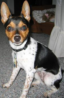

In [71]:
img = data_preprocessing(img_filenames_th[1500][:-6]+'.jpg',0)
img = transform1(img)
img